In [61]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import json
import kagglehub
import matplotlib.pyplot as plt
from FastCCM.utils import get_td_embedding_np
from sklearn.metrics import pairwise_distances
from FastCCM import PairwiseCCM
from FastCCM import CCM_utils
from manifold_learning import imd_nd_smap, imd_reg_smap


In [62]:
import numpy as np

def ema(values, window):
    """
    Compute the Exponential Moving Average (EMA) of a 1D numpy array in a causal way.

    Parameters:
        values (np.ndarray): 1D array of values.
        window (int): Lookback period for the EMA.

    Returns:
        np.ndarray: An array of EMA values (same length as `values`).
    """
    alpha = 2 / (window + 1)
    ema_values = np.empty_like(values, dtype=float)
    ema_values[0] = values[0]  # initialize with the first value

    # Each EMA value uses only current and previous EMA value (i.e. no future info)
    for i in range(1, len(values)):
        ema_values[i] = alpha * values[i] + (1 - alpha) * ema_values[i - 1]
    return ema_values

def compute_rsi(close, window=14):
    """
    Compute the Relative Strength Index (RSI) in a causal manner.

    For each time t, the RSI is computed using only data from time 0 to t.
    Uses Wilder's smoothing method.

    Parameters:
        close (np.ndarray): 1D array of close prices.
        window (int): Lookback period for RSI calculation.

    Returns:
        np.ndarray: Array of RSI values. The first `window` values are set to np.nan
                    because there is insufficient history to compute a reliable RSI.
    """
    close = np.asarray(close)
    rsi = np.empty_like(close, dtype=float)
    rsi[:window] = np.nan  # not enough data for the initial window

    # Compute price changes (only differences between consecutive observations)
    delta = np.diff(close)
    gains = np.where(delta > 0, delta, 0)
    losses = np.where(delta < 0, -delta, 0)

    # First average gain and loss: use simple mean of the first `window` changes
    avg_gain = np.mean(gains[:window])
    avg_loss = np.mean(losses[:window])
    
    # Compute the first RSI value at the (window)th index
    if avg_loss == 0:
        rsi[window] = 100
    else:
        rs = avg_gain / avg_loss
        rsi[window] = 100 - (100 / (1 + rs))

    # Compute subsequent RSI values in a causal fashion
    for i in range(window, len(close) - 1):
        # The gain/loss at time i+1 is computed using the difference from i to i+1
        gain = gains[i]  # gain at time i+1 (using 0-based indexing for delta)
        loss = losses[i]
        
        # Update averages using Wilder's smoothing (using only past info)
        avg_gain = (avg_gain * (window - 1) + gain) / window
        avg_loss = (avg_loss * (window - 1) + loss) / window
        
        if avg_loss == 0:
            rsi[i + 1] = 100
        else:
            rs = avg_gain / avg_loss
            rsi[i + 1] = 100 - (100 / (1 + rs))
    
    return rsi

def compute_macd(close, fast=12, slow=26, signal=9):
    """
    Compute the Moving Average Convergence Divergence (MACD) indicator causally.

    All computations are done recursively so that at each time step t only data up to t is used.

    Parameters:
        close (np.ndarray): 1D array of close prices.
        fast (int): Period for the fast EMA (default is 12).
        slow (int): Period for the slow EMA (default is 26).
        signal (int): Period for the signal line EMA (default is 9).

    Returns:
        tuple: (macd_line, signal_line, macd_histogram) as numpy arrays.
    """
    close = np.asarray(close)

    # Compute fast and slow EMAs (both are causal by definition)
    ema_fast = ema(close, fast)
    ema_slow = ema(close, slow)
    
    # MACD line: difference of fast EMA and slow EMA
    macd_line = ema_fast - ema_slow
    
    # Signal line: EMA of the MACD line (again, computed causally)
    signal_line = ema(macd_line, signal)
    
    # MACD histogram: difference between MACD line and its signal line
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

def add_rsi_macd_numpy(close_prices, rsi_window=14, macd_fast=12, macd_slow=26, macd_signal=9):
    """
    Given a numpy array of close prices, compute the RSI and MACD indicators causally.

    Parameters:
        close_prices (np.ndarray): 1D array of close prices.
        rsi_window (int): Lookback period for RSI (default 14).
        macd_fast (int): Lookback period for the fast EMA in MACD (default 12).
        macd_slow (int): Lookback period for the slow EMA in MACD (default 26).
        macd_signal (int): Lookback period for the signal line in MACD (default 9).

    Returns:
        tuple: (rsi, macd_line, macd_signal_line, macd_histogram)
    """
    rsi = compute_rsi(close_prices, window=rsi_window)
    macd_line, macd_signal_line, macd_histogram = compute_macd(close_prices, fast=macd_fast, slow=macd_slow, signal=macd_signal)
    return rsi, macd_line, macd_signal_line, macd_histogram



In [63]:

path = kagglehub.dataset_download("jkraak/bitcoin-price-dataset")
btc_price = pd.read_csv(path + "/bitcoin_2017_to_2023.csv")[::-1]


In [64]:
rsi, macd_line, macd_signal_line, macd_diff = add_rsi_macd_numpy(btc_price["close"].to_numpy())

In [65]:
btc_price["rsi"] = rsi
btc_price["macd_line"] = macd_line
btc_price["macd_signal_line"] = macd_signal_line
btc_price["macd_diff"] = macd_diff


In [66]:
btc_data = btc_price[-300000:].to_numpy()[:,1:].astype(np.float32)
btc_data[:,[1,2,3,4]] = np.log(btc_data[:,[1,2,3,4]]+1)
#btc_data[1:,[0,1,2,4]] = np.diff(btc_data[:,[0,1,2,4]],axis=0) 
btc_data = StandardScaler().fit_transform(btc_data)
#btc_data = btc_data[1:]
btc_data = btc_data[:,[3,1,2,4]]#,9,10,11,12]]

In [67]:
btc_price.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,rsi,macd_line,macd_signal_line,macd_diff
3125999,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851,3,0.075183,320.390851,NaN,0.000000,0.000000,0.000000
3125998,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
3125997,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,2,0.261074,1117.542921,NaN,1.522051,0.304410,1.217641
3125996,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,3,0.012008,51.171852,NaN,1.175145,0.478557,0.696588
3125995,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,1,0.140796,599.999338,NaN,0.889960,0.560838,0.329123


In [68]:

btc_data_td = get_td_embedding_np(btc_data[:],20,1).copy()#.reshape(-1,50 * 8)
btc_data_td[:,:,[0,1,2,3]] = (btc_data_td[:,:,[0,1,2,3]] - btc_data_td[:,:,[0,1,2,3]][:,[19]])
btc_data_td[:,:,[0,1,2,3]] = (btc_data_td[:,:,[0,1,2,3]] / btc_data_td[:,:,[0,1,2,3]].mean(axis=1).std(axis=0)[None,None,:])

In [69]:

btc_data_td = btc_data_td[:,:,0]#.reshape(-1,50 * 4)

In [70]:
X_train = btc_data_td[:-100000]
y_train = np.diff(btc_data,axis=0)[:,[0]][-btc_data_td.shape[0]:,:][:-100000]
X_test = btc_data_td[-100000:]
y_test = np.diff(btc_data,axis=0)[:,[0]][-btc_data_td.shape[0]:,:][-100000:]


In [170]:

trainer = imd_reg_smap.IMD_reg_smap(X_train.shape[1], embed_dim=10, subtract_corr=False, device="cuda")

In [171]:
trainer.fit(X_train, y_train, sample_len=270, library_len=5000,
                exclusion_rad=150,theta=7,tp=1,
                epochs=1500, num_batches=32,optimizer="RMSprop", tp_policy="range",learning_rate=0.001)

Epoch 1/1500, Loss: 0.9704
Epoch 2/1500, Loss: 0.9811
Epoch 3/1500, Loss: 0.9679
Epoch 4/1500, Loss: 0.9818
Epoch 5/1500, Loss: 0.9829
Epoch 6/1500, Loss: 0.9816
Epoch 7/1500, Loss: 0.9797
Epoch 8/1500, Loss: 0.9838
Epoch 9/1500, Loss: 0.9789
Epoch 10/1500, Loss: 0.9786
Epoch 11/1500, Loss: 0.9883
Epoch 12/1500, Loss: 0.9885
Epoch 13/1500, Loss: 0.9839
Epoch 14/1500, Loss: 0.9798
Epoch 15/1500, Loss: 0.9867
Epoch 16/1500, Loss: 0.9873
Epoch 17/1500, Loss: 0.9895
Epoch 18/1500, Loss: 0.9907
Epoch 19/1500, Loss: 0.9871
Epoch 20/1500, Loss: 0.9831
Epoch 21/1500, Loss: 0.9827
Epoch 22/1500, Loss: 0.9773
Epoch 23/1500, Loss: 0.9768
Epoch 24/1500, Loss: 0.9873
Epoch 25/1500, Loss: 0.9718
Epoch 26/1500, Loss: 0.9739
Epoch 27/1500, Loss: 0.9819
Epoch 28/1500, Loss: 0.9836
Epoch 29/1500, Loss: 0.9831
Epoch 30/1500, Loss: 0.9826
Epoch 31/1500, Loss: 0.9719
Epoch 32/1500, Loss: 0.9810
Epoch 33/1500, Loss: 0.9795
Epoch 34/1500, Loss: 0.9861
Epoch 35/1500, Loss: 0.9888
Epoch 36/1500, Loss: 0.9859
E

KeyboardInterrupt: 

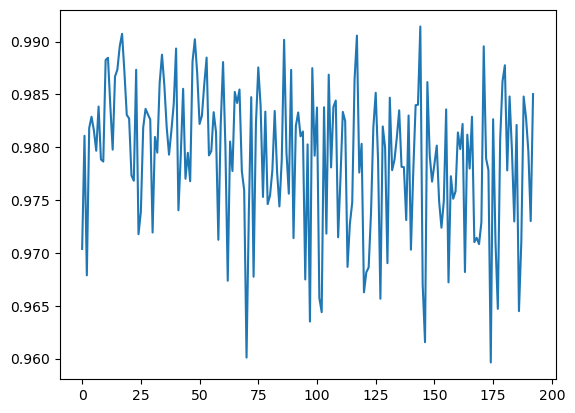

In [172]:
plt.plot(trainer.get_loss_history())

In [173]:
unmixed_train = trainer.predict(X_train)
unmixed_test = trainer.predict(X_test)

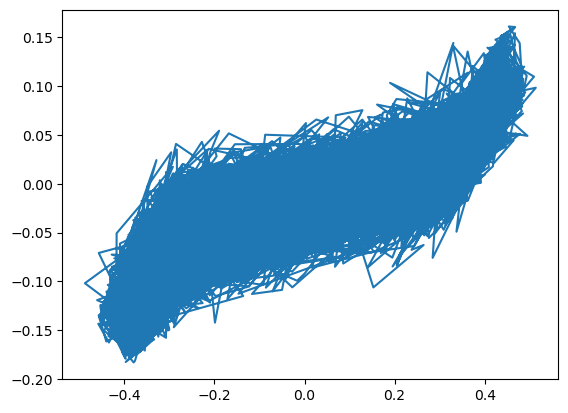

In [174]:
plt.plot(unmixed_train[:,0,0],unmixed_train[:,0,1])

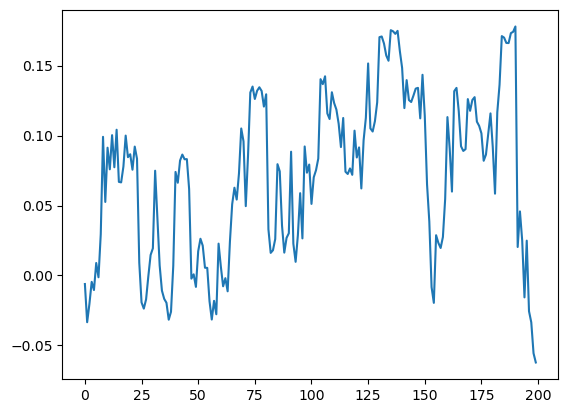

In [151]:
plt.plot(unmixed_train[:200,0,0])

In [155]:
PairwiseCCM("cpu").compute(np.transpose(unmixed_train,(1,0,2)), y_train[None,:,[0]],5000,1000,20,1,"smap",theta=7)

array([[[-0.11973093]]], dtype=float32)

In [120]:
PairwiseCCM("cpu").compute(np.transpose(unmixed_test,(1,0,2)), y_test[None,:,[0]],5000,1000,20,2,"smap",theta=5)

array([[[0.02859553]]], dtype=float32)

In [142]:

temp_pred = np.array([
        (PairwiseCCM("cpu").predict(np.transpose(unmixed_test,(1,0,2)), y_test[None,:,[0]][:,:],2000,150,1,"smap",theta=7).squeeze()) 
        for i in range(10)
    ]).mean(axis=0)

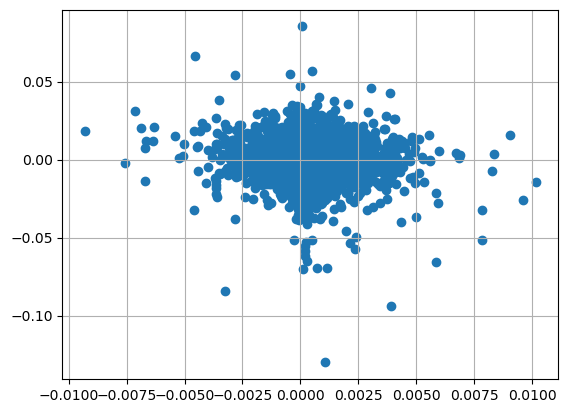

In [144]:
plt.scatter(temp_pred, y_test[1:,0])
plt.grid()

In [145]:
import numpy as np
from scipy.stats import pearsonr


# Calculate Pearson correlation coefficient and p-value
r, p_value = pearsonr(temp_pred, y_test[1:,0])

print("Correlation coefficient (r):", r)
print("P-value:", p_value)


Correlation coefficient (r): -0.020765186295738765
P-value: 5.1297165732347074e-11


(0.0, 200.0)

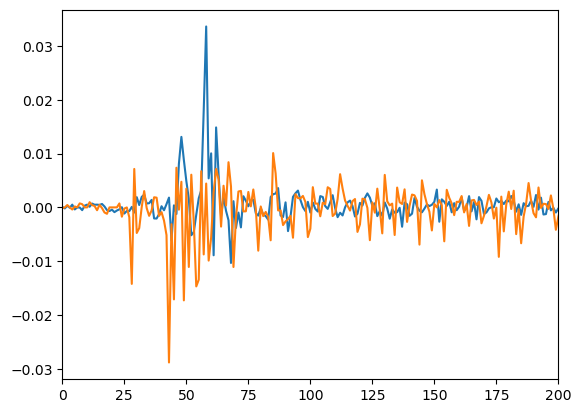

In [146]:
plt.plot(temp_pred[:1000]*5)
plt.plot(y_test[1:1000,0])
plt.xlim(0,200)

In [345]:
n_exp = 30
models = []
unmixed_train_all = []
unmixed_test_all = []

for exp in range(n_exp):

    trainer = imd_reg_smap.IMD_reg_smap(X_train.shape[1], embed_dim=10,  subtract_corr=False, device="cuda")

    trainer.fit(X_train, y_train, sample_len=170, library_len=700,
            exclusion_rad=150,theta=5,tp=1,
            epochs=500, num_batches=32,optimizer="SGD", tp_policy="range",learning_rate=0.01)
    
    models += [trainer.model]
    
    unmixed_train = trainer.predict(X_train)
    unmixed_test = trainer.predict(X_test)
    unmixed_train_all += [unmixed_train.copy()]
    unmixed_test_all += [unmixed_test.copy()]


Epoch 1/500, Loss: 0.9689
Epoch 2/500, Loss: 0.9464
Epoch 3/500, Loss: 0.8605
Epoch 4/500, Loss: 0.7666
Epoch 5/500, Loss: 0.6561
Epoch 6/500, Loss: 0.6455
Epoch 7/500, Loss: 0.5609
Epoch 8/500, Loss: 0.5690
Epoch 9/500, Loss: 0.5764
Epoch 10/500, Loss: 0.5311
Epoch 11/500, Loss: 0.5294
Epoch 12/500, Loss: 0.4963
Epoch 13/500, Loss: 0.4510
Epoch 14/500, Loss: 0.4111
Epoch 15/500, Loss: 0.4291
Epoch 16/500, Loss: 0.4192
Epoch 17/500, Loss: 0.4641
Epoch 18/500, Loss: 0.4111
Epoch 19/500, Loss: 0.4049
Epoch 20/500, Loss: 0.4163
Epoch 21/500, Loss: 0.4111
Epoch 22/500, Loss: 0.3907
Epoch 23/500, Loss: 0.4035
Epoch 24/500, Loss: 0.3915
Epoch 25/500, Loss: 0.3757
Epoch 26/500, Loss: 0.3605
Epoch 27/500, Loss: 0.3607
Epoch 28/500, Loss: 0.3375
Epoch 29/500, Loss: 0.3655
Epoch 30/500, Loss: 0.3664
Epoch 31/500, Loss: 0.3424
Epoch 32/500, Loss: 0.3350
Epoch 33/500, Loss: 0.3554
Epoch 34/500, Loss: 0.3380
Epoch 35/500, Loss: 0.3527
Epoch 36/500, Loss: 0.3157
Epoch 37/500, Loss: 0.3550
Epoch 38/5

KeyboardInterrupt: 

In [346]:
unmixed_train_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_train_all])
unmixed_test_all_concat = np.concatenate([np.transpose(i,(1,0,2)) for i in unmixed_test_all])

In [348]:

ccm_unmixed_train = PairwiseCCM().compute(unmixed_train_all_concat,unmixed_train_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)
ccm_unmixed_test = PairwiseCCM().compute(unmixed_test_all_concat,unmixed_test_all_concat,1500,600,60,0,method="simplex",nbrs_num=10,).mean(axis=0)

ccm_unmixed_train[ccm_unmixed_train<0]=0
ccm_unmixed_test[ccm_unmixed_test<0]=0


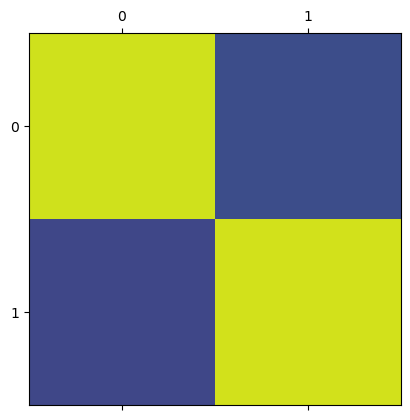

In [349]:


plt.matshow(ccm_unmixed_train,vmin=0,vmax=1)


In [86]:

trainer = imd_nd_smap.IMD_nD_smap(X_train.shape[1], embed_dim=10, n_components=1, subtract_corr=False, device="cuda")

trainer.fit(X_train, sample_len=170, library_len=700, 
                exclusion_rad=150, theta=5, tp=100, 
                epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=None)

Epoch 1/1000, Loss: 0.9387
Epoch 2/1000, Loss: 0.9192
Epoch 3/1000, Loss: 0.9039
Epoch 4/1000, Loss: 0.8965
Epoch 5/1000, Loss: 0.8910
Epoch 6/1000, Loss: 0.8920
Epoch 7/1000, Loss: 0.8852
Epoch 8/1000, Loss: 0.8782
Epoch 9/1000, Loss: 0.8784
Epoch 10/1000, Loss: 0.8701
Epoch 11/1000, Loss: 0.8713
Epoch 12/1000, Loss: 0.8673
Epoch 13/1000, Loss: 0.8762
Epoch 14/1000, Loss: 0.8673
Epoch 15/1000, Loss: 0.8663
Epoch 16/1000, Loss: 0.8677
Epoch 17/1000, Loss: 0.8662
Epoch 18/1000, Loss: 0.8597
Epoch 19/1000, Loss: 0.8597
Epoch 20/1000, Loss: 0.8628
Epoch 21/1000, Loss: 0.8602
Epoch 22/1000, Loss: 0.8550
Epoch 23/1000, Loss: 0.8563
Epoch 24/1000, Loss: 0.8597
Epoch 25/1000, Loss: 0.8567
Epoch 26/1000, Loss: 0.8583
Epoch 27/1000, Loss: 0.8541
Epoch 28/1000, Loss: 0.8539
Epoch 29/1000, Loss: 0.8532
Epoch 30/1000, Loss: 0.8543
Epoch 31/1000, Loss: 0.8527
Epoch 32/1000, Loss: 0.8525
Epoch 33/1000, Loss: 0.8558
Epoch 34/1000, Loss: 0.8541
Epoch 35/1000, Loss: 0.8538
Epoch 36/1000, Loss: 0.8541
E

KeyboardInterrupt: 